In [2]:
import os
from pprint import pprint
from tqdm import tqdm
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from ydata_profiling import ProfileReport
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Read dataset 1
# Attack_free, DoS, Fuzzy, Impersonation
ref_directory = 'D:/code/ids/CANintrusion/'
dataset1 = [pd.DataFrame(columns=["Timestamp", "ID", "DLC", "Data"]) for x in range(4)]
for index, file in tqdm(enumerate([x for x in os.listdir(ref_directory) if x.endswith('.csv')])):
    dataset1[index] = pd.read_csv(ref_directory + file)
    dataset1[index] = dataset1[index].fillna("-1")
    for column in range(8):
        dataset1[index][str(column+1)] = dataset1[index]['Data'].str[2*column:(2*column)+2]
    dataset1[index] = dataset1[index].drop(["Data"], axis=1)
    dataset1[index]["Flag"] = -1
    dataset1[index]["ID"] = dataset1[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))


4it [00:10,  2.74s/it]


In [4]:
pprint(dataset1[1].head(50))

    Timestamp                            ID  DLC   1   2   3   4   5   6   7  \
0    0.000000  0000000000000000000000000000    8  00  00  00  00  00  00  00   
1    0.000271  0000000010000000000000000000    8  00  17  dc  09  16  11  16   
2    0.000495  0000000000000000000000000000    8  00  00  00  00  00  00  00   
3    0.000736  0000000010000001000000000000    8  40  84  87  00  00  00  00   
4    0.000983  0000000000000000000000000000    8  00  00  00  00  00  00  00   
5    0.001239  0000000101100101000000000000    8  00  08  80  00  00  00  08   
6    0.001484  0000000000000000000000000000    8  00  00  00  00  00  00  00   
7    0.001736  0000000110001111000000000000    8  00  3f  16  00  00  3f  00   
8    0.001984  0000000000000000000000000000    8  00  00  00  00  00  00  00   
9    0.002229  0000001010100000000000000000    8  62  00  87  9d  bc  0c  b7   
10   0.002465  0000000000000000000000000000    8  00  00  00  00  00  00  00   
11   0.002654  0000001010110000000000000

In [5]:
# Convert dataset2 to csv
# Attack_free
ref_directory = 'D:/code/ids/CarHacking/'
for file_path in os.listdir(ref_directory):
    if file_path.endswith('.txt'):
        with open(ref_directory + file_path, "r") as file:

            with open(ref_directory + file_path[:-4] + ".csv", 'w') as output_file:
                data = file.read()
                writer = csv.writer(output_file)

                for index, row in tqdm(enumerate(data.split("\n")[:-1])):

                    writer.writerow([
                        float(row.split("Timestamp:")[1].split("ID")[0].strip()),
                        (row.split("ID:")[1].split("DLC")[0].strip().replace(" ", "")),
                        int(row.split("DLC:")[1][:2].strip()),
                        row.split("DLC:")[1][6:].strip().replace(" ", "")
                    ])


988871it [00:03, 257400.15it/s]


In [6]:
# Read dataset 2
# Attack_free, DoS, Fuzzy, Gear, RPM
ref_directory = 'D:/code/ids/CarHacking/'
dataset2 = [pd.DataFrame(columns=["Timestamp", "ID", "DLC", "Data"]) for x in range(5)]
for index, file in tqdm(enumerate([x for x in os.listdir(ref_directory) if x.endswith('.csv')])):

    if index == 3:
        dataset2[index] = pd.read_csv(ref_directory + file, names=["Timestamp", "ID", "DLC", "Data"])
        dataset2[index] = dataset2[index].fillna("-1")
        for column in range(8):
            dataset2[index][str(column+1)] = dataset2[index]["Data"].str[2*column:(2*column)+2]
        dataset2[index] = dataset2[index].drop(["Data"], axis=1)
        dataset2[index]["Flag"] = -1
        dataset2[index]["ID"] = dataset2[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))

    else:
        dataset2[index] = pd.read_csv(ref_directory + file, names=["Timestamp", "ID", "DLC", "1", "2", "3", "4", "5", "6", "7", "8", "Flag"])
        condition = dataset2[index]['Flag'].isna()
        for row_index, row in dataset2[index][condition].iterrows():
            column = 0
            for column in range(1, 9):
                if type(dataset2[index].at[row_index, str(column)]) != str:
                    dataset2[index].at[row_index, "Flag"] = dataset2[index].at[row_index, str(column-1)]
                    dataset2[index].at[row_index, str(column-1)] = " "
                    break
        dataset2[index]["ID"] = dataset2[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))

    dataset2[index] = dataset2[index].fillna(" ")

5it [00:51, 10.21s/it]


In [7]:
pprint(dataset2[0].head())

      Timestamp                            ID  DLC   1   2   3   4   5   6  \
0  1.478198e+09  0000000000000000001100010110    8  05  21  68  09  21  21   
1  1.478198e+09  0000000000000000000110001111    8  fe  5b  00  00  00  3c   
2  1.478198e+09  0000000000000000001001100000    8  19  21  22  30  08  8e   
3  1.478198e+09  0000000000000000001010100000    8  64  00  9a  1d  97  02   
4  1.478198e+09  0000000000000000001100101001    8  40  bb  7f  14  11  20   

    7   8 Flag  
0  00  6f    R  
1  00  00    R  
2  6d  3a    R  
3  bd  00    R  
4  00  14    R  


In [8]:
# Convert dataset3 to csv
ref_directory = 'D:/code/ids/CANintrusion/'
for file_path in os.listdir(ref_directory):
    if file_path.endswith('.txt'):
        with open(ref_directory + file_path, "r") as file:

            with open(ref_directory + file_path[:-4] + ".csv", 'w') as output_file:
                data = file.read()
                writer = csv.writer(output_file)
                writer.writerow(["Timestamp", "ID", "DLC", "Data"])

                for index, row in tqdm(enumerate(data.split("\n")[:-1])):

                    writer.writerow([
                        float(row.split("Timestamp:")[1].split("ID")[0].strip()),
                        (row.split("ID:")[1].split("DLC")[0].strip().replace(" ", "")),
                        int(row.split("DLC:")[1][:2].strip()),
                        row.split("DLC:")[1][6:].strip().replace(" ", "")
                    ])

2369398it [00:08, 282375.59it/s]
656579it [00:02, 289352.99it/s]
591990it [00:02, 285067.29it/s]
995472it [00:03, 257079.13it/s]


In [9]:
# Read dataset 3
# Attack_free, DoS, Fuzzy, Gear, RPM
ref_directory = 'D:/code/ids/Survival/'
dataset3 = [pd.DataFrame(columns=["Timestamp", "ID", "DLC", "Data"]) for x in range(12)]
for index, file in tqdm(enumerate([x for x in os.listdir(ref_directory) if x.endswith('.txt')])): # dataset files are csv but mislabeled txt

    dataset3[index] = pd.read_csv(ref_directory + file, names=["Timestamp", "ID", "DLC", "1", "2", "3", "4", "5", "6", "7", "8", "Flag"])

    if "FreeDriving" in file and "SONATA" not in file:
        dataset3[index]["Data"] = dataset3[index]["1"]
        dataset3[index] = dataset3[index].drop(["1", "2", "3", "4", "5", "6", "7", "8", "Flag"], axis=1)
        dataset3[index] = dataset3[index].drop(["Data"], axis=1).join(dataset3[index].Data.str.split(expand=True))
        dataset3[index].columns.values[3:11] = ["1", "2", "3", "4", "5", "6", "7", "8"]
        dataset3[index]["Flag"] = -1
        dataset3[index]["ID"] = dataset3[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))

    elif "FreeDriving" in file and "SONATA" in file:
        dataset3[index]["Flag"] = -1
        dataset3[index]["ID"] = dataset3[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))

    else:
        dataset3[index]["ID"] = dataset3[index]['ID'].apply(lambda x: format(int(x, 16), '0b').rjust(28, "0"))
        condition = dataset3[index]['Flag'].isna()
        for row_index, row in dataset3[index][condition].iterrows():
            for column in range(1, 9):
                if type(dataset3[index].at[row_index, str(column)]) != str:
                    dataset3[index].at[row_index, "Flag"] = dataset3[index].at[row_index, str(column-1)]
                    dataset3[index].at[row_index, str(column-1)] = " "
                    break
                elif column == 8 and dataset3[index].at[row_index, str(column)] in ["R", "T"]:
                    dataset3[index].at[row_index, "Flag"] = dataset3[index].at[row_index, str(column)]
                    dataset3[index].at[row_index, str(column)] = " "
                    break

    dataset3[index] = dataset3[index].fillna(" ")

12it [00:18,  1.57s/it]


In [10]:
pprint(dataset3[3].head(50))

       Timestamp                            ID  DLC   1   2   3   4   5   6  \
0   1.513920e+09  0000000000000000000111100101    8  5C  00  30  30  00  00   
1   1.513920e+09  0000000000000000000011000111    4  00  07  02  20           
2   1.513920e+09  0000000000000000000111100001    7  00  00  00  00  02  00   
3   1.513920e+09  0000000000000000000011111001    8  00  00  40  00  00  00   
4   1.513920e+09  0000000000000000000111110001    8  AE  0A  00  00  18  00   
5   1.513920e+09  0000000000000000000010101010    8  2B  E7  2C  5B  46  53   
6   1.513920e+09  0000000000000000000010111110    6  08  00  00  03  E9  FE   
7   1.513920e+09  0000000000000000000011001001    8  84  0D  20  0A  00  00   
8   1.513920e+09  0000000000000000000011000001    8  61  17  48  10  21  43   
9   1.513920e+09  0000000000000000000011000101    8  20  16  D4  60  23  AC   
10  1.513920e+09  0000000000000000000011010001    7  80  00  BF  FE  00  FE   
11  1.513920e+09  0000000000000000000110001110    8 

In [11]:
# Modify datasets for ML training by replacing blanks with -1s, converting hex to int, and converting flags to boolean int
datasets = [dataset1, dataset2, dataset3]
for di, dataset in enumerate(datasets):
    for dfi, df in tqdm(enumerate(dataset)):
        df = df.replace('', ' ')
        df = df.replace(' ', '-1')
        for column in ["ID", "1", "2", "3", "4", "5", "6", "7", "8"]:
            if type(df.at[0, column]) == str:
                df[column] = df[column].apply(int, base=16)
                pass
        for column in ["Flag"]:
            df[column] = df[column].apply(lambda x: 1 if x == "T" else 0 if x == "R" else -1)
        datasets[di][dfi] = df
dataset1, dataset2, dataset3 = datasets

4it [00:27,  6.86s/it]
5it [01:33, 18.76s/it]
12it [00:08,  1.41it/s]


<AxesSubplot:>

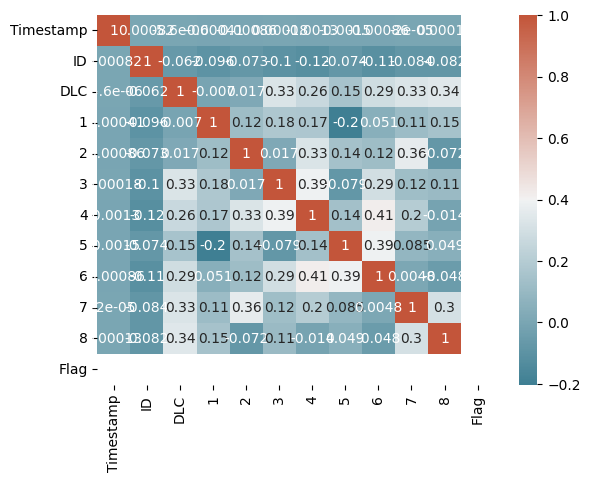

In [12]:
corr = dataset3[3].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

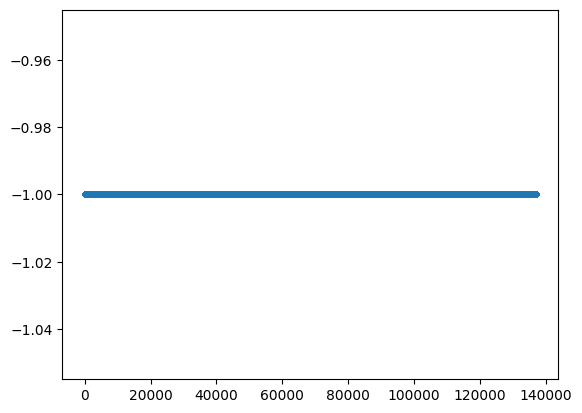

In [13]:
plt.plot(dataset3[3]['Flag'], marker='.')
plt.show()

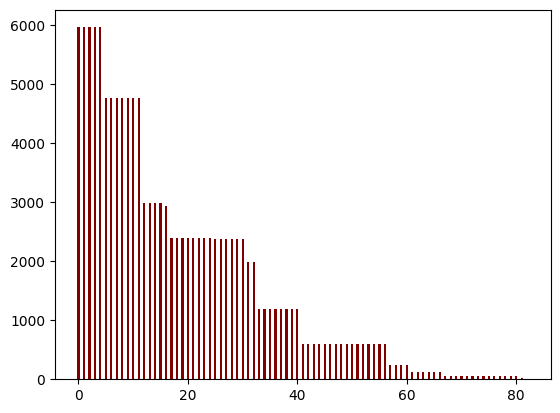

In [14]:
plt.bar([x for x in range(len(dataset3[3]['ID'].value_counts()))], dataset3[3]['ID'].value_counts(), color ='maroon', width=0.4)
plt.show()

In [15]:
df = dataset3[8]

In [16]:
print(f'0s: {df[df["Flag"] == 0].shape}')
print(f'1s: {df[df["Flag"] == 1].shape}')
print(f'-1s: {df[df["Flag"] == -1].shape}')

0s: (59853, 12)
1s: (5812, 12)
-1s: (0, 12)


In [17]:
# X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :3], df.iloc[:, -1], test_size=0.3, random_state=42)
split_index = int(0.7 * len(df))
X_train = df.iloc[:split_index, :-1]
y_train = df.iloc[:split_index, -1]
X_test = df.iloc[split_index:, :-1]
y_test = df.iloc[split_index:, -1]

In [ ]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

In [18]:
reg = LogisticRegression(class_weight="balanced").fit(X_train, y_train)
print(f"Regularized score on train: {reg.score(X_train, y_train)}")

Regularized score on train: 0.8986620254541499


C:\Users\KARNAV\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
print(f"Regularized score on test: {reg.score(X_test, y_test)}")

Regularized score on test: 0.9414213197969543


In [20]:
y_hat = reg.predict(X_test)
pprint(y_hat)
pprint(set(y_hat))

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)
{0}


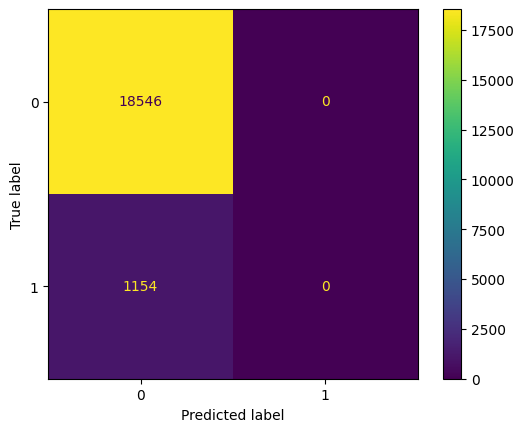

In [21]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [22]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_hat)}")
print(f"Precision: {metrics.precision_score(y_test, y_hat)}")
print(f"Recall: {metrics.recall_score(y_test, y_hat)}")
print(f"Sensitivity: {metrics.recall_score(y_test, y_hat, pos_label=0)}")
print(f"F1: {metrics.f1_score(y_test, y_hat)}")

Accuracy: 0.9414213197969543
Precision: 0.0
Recall: 0.0
Sensitivity: 1.0
F1: 0.0


C:\Users\KARNAV\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
print(f"Regularized score on train: {knn.score(X_train, y_train)}")

Regularized score on train: 0.9965626019797672


In [24]:
print(f"Regularized score on test: {knn.score(X_test, y_test)}")
print(knn.score(dataset3[7].iloc[:, :11], dataset3[7].iloc[:, 11]))

Regularized score on test: 0.9929441624365483
0.34301614210953046


In [25]:
y_hat = knn.predict(X_test)
pprint(y_hat)
pprint(set(y_hat))

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)
{0, 1}


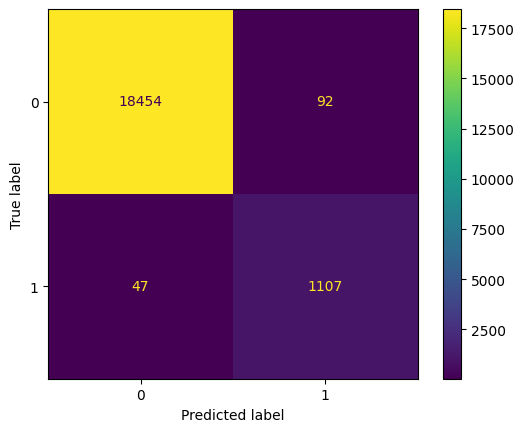

In [26]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot()
plt.show()

In [27]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_hat)}")
print(f"Precision: {metrics.precision_score(y_test, y_hat)}")
print(f"Recall: {metrics.recall_score(y_test, y_hat)}")
print(f"Sensitivity: {metrics.recall_score(y_test, y_hat, pos_label=0)}")
print(f"F1: {metrics.f1_score(y_test, y_hat)}")

Accuracy: 0.9929441624365483
Precision: 0.9232693911592994
Recall: 0.9592720970537262
Sensitivity: 0.9950393615874042
F1: 0.940926476838079


In [28]:
# svm = SVC(class_weight="balanced", C=0.001, gamma=1)
svm.fit(X_train, y_train)
print(f"SVM score on train: {svm.score(X_train, y_train)}")

NameError: name 'svm' is not defined

In [ ]:
print(f"SVM score on test: {svm.score(X_test, y_test)}")

In [ ]:
y_hat = svm.predict(X_test)
pprint(y_hat)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_hat)}")
print(f"Precision: {metrics.precision_score(y_test, y_hat)}")
print(f"Recall: {metrics.recall_score(y_test, y_hat)}")
print(f"Sensitivity: {metrics.recall_score(y_test, y_hat, pos_label=0)}")
print(f"F1: {metrics.f1_score(y_test, y_hat)}")

In [ ]:
n_steps = 100
n_features = df.shape[1]
df = df[df["Flag"]==0]

In [ ]:
X = []
y = []
for row_index in range(n_steps, len(df)):
    X.append(df.iloc[row_index - n_steps: row_index, :])
    y.append(df.iloc[row_index, :])

X = np.array(X)
y = np.array(y)

for i in range(len(X)):
    print(f"X: {X[i]}")
    print(f"y: {y[i]}")

In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(units=n_features))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs=100000, batch_size=32)

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Mean Squared Error:", loss)

In [ ]:
yhat = model.predict(X_test, verbose=1)
print(yhat)